# Retro Inversian

FASTAを入力してペプチドのタイプを選択すると、L体とD体の構造を描画します。

1. FASTAを入力する
2. Linerは1、Head to Tailは2、Cystein Cyclizationは3、Disulfideは4を選択する

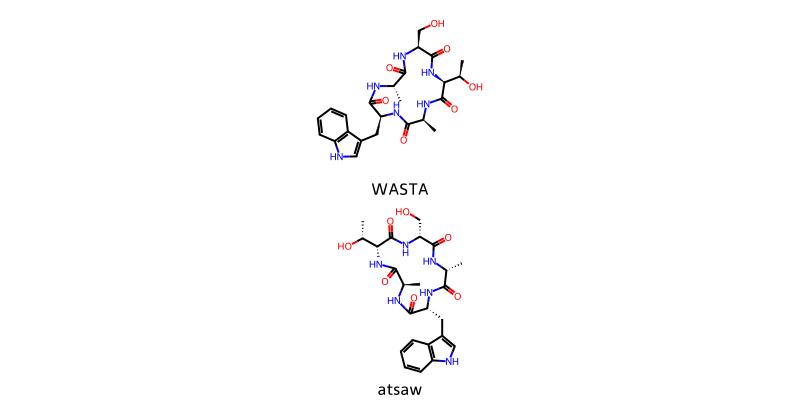

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor, AllChem
from rdkit.Chem.Draw import IPythonConsole
# 環状化合物をきれいに描画 https://future-chem.com/rdkit-coordgen/
rdDepictor.SetPreferCoordGen(True)

# aminoacid format
laa = 'N[C@@]([H])({X})C(=O)'
daa = 'N[C@@]({X})([H])C(=O)'

# residue dict
amino_acids = {
    'G': '[H]',
    'A': 'C',
    'V': 'C(C)C',
    'L': 'CC(C)C',
    'I': 'C(C)CC',
    'M': 'CCSC',
    'F': 'CC1=CC=CC=C1',
    'W': 'CC1=CNC2=C1C=CC=C2',
    'S': 'CO',
    'C': 'CS',
    'Y': 'CC1=CC=C(C=C1)O',
    'N': 'C(C(=O)N)',
    'Q': 'C(CC(=O)N)',
    'D': 'C(C(=O)O)',
    'E': 'C(CC(=O)O)',
    'H': 'C(C1=CNC=N1)',
    'K': 'CCCCN',
    'R': 'CCCNC(=N)N',
}

# insert variable to format
laaa = {k: laa.format(X=v) for k, v in amino_acids.items()}
daaa = {k: daa.format(X=v) for k, v in amino_acids.items()}

# add prolines and threonines
laaa['P'] = 'N1[C@@]([H])(CCC1)C(=O)'
daaa['P'] = 'N1[C@@](CCC1)([H])C(=O)'
laaa['T'] = 'N[C@@]([H])([C@]([H])(O)C)C(=O)'
daaa['T'] = 'N[C@@]([C@]([H])(O)C)([H])C(=O)'

# PepType
PepType = {
    '1' : 'Liner',
    '2' : 'Head to Tail',
    '3' : 'Cystein Cyclization',
    '4' : 'Symple Disulfide'
}


FASTA = input('FASTA?')
fasta = FASTA[::-1]
mode = input('Liner:1, Head to Tail:2, Cyctein Cyclization:3, Disulfide:4')

# FASTA = 'CAWAFAAAC'
# fasta = FASTA[::-1]
# type = 'Disulfide'


l_sec = ''.join([laaa[aa] for aa in FASTA])
d_sec = ''.join([daaa[aa] for aa in fasta])

# liner
l_liner = l_sec + 'O'
d_liner = d_sec + 'O'

# Head to Tail
l_ht = 'N9' + l_sec[1:-4] + '9(=O)'
d_ht = 'N9' + d_sec[1:-4] + '9(=O)'

# Cystein Cyclization
l_cc = 'C9C(=O)' + l_sec + 'N[C@@]([H])(CS9)C(=O)N'
d_cc = 'C9C(=O)' + d_sec + 'N[C@@](CS9)([H])C(=O)N'

# Simple Disulfide
l_ds = 'N[C@@]([H])(CS9)C(=O)' + l_sec + 'N[C@@]([H])(CS9)C(=O)O'
d_ds = 'N([H])[C@@](CS9)C(=O)' + d_sec + 'N([H])[C@@](CS9)C(=O)O'

# Draw.MolToImage(Chem.MolFromSmiles(l_ht), size=(1000, 400))

if mode == '2':
    l_smiles = l_ht
    d_smiles = d_ht
elif mode == '3':
    l_smiles = l_cc
    d_smiles = d_cc
elif mode == '4':
    l_smiles = l_ds
    d_smiles = d_ds
else:
    l_smiles = l_liner
    d_smiles = d_liner

# generate molecules
l_mol = Chem.MolFromSmiles(l_smiles)
d_mol = Chem.MolFromSmiles(d_smiles)

# output
Draw.MolsToGridImage([l_mol, d_mol], molsPerRow=1, subImgSize=(800,200), legends=[FASTA, fasta.lower()])

### 分子を重ね合わせて表示する

In [4]:
import copy
from rdkit.Chem import AllChem, rdMolAlign, Draw, rdMolDescriptors
import py3Dmol

# generate 3D conformations
Chem.AddHs(l_mol)
AllChem.EmbedMolecule(l_mol)
# AllChem.UFFOptimizeMolecule(l_mol)
Chem.AddHs(d_mol)
AllChem.EmbedMolecule(d_mol)
# AllChem.UFFOptimizeMolecule(d_mol)
mols = [l_mol, d_mol]

crippen_mols = [copy.deepcopy(m) for m in mols]
crippen_contribs = [rdMolDescriptors._CalcCrippenContribs(m) for m in crippen_mols]
crippen_o3as = [AllChem.GetCrippenO3A(prbMol=crippen_mols[i], refMol=crippen_mols[0],
                                     prbCrippenContribs=crippen_contribs[i],
                                     refCrippenContribs=crippen_contribs[0]) 
               for i in range(1, len(crippen_mols))]

view = py3Dmol.view(width=1000, height=400)
view.addModel(Chem.MolToMolBlock(crippen_mols[0]), 'sdf')
crippen_o3as[0].Align()
view.addModel(Chem.MolToMolBlock(crippen_mols[1]), 'sdf')
view.setStyle({'stick': {}})
view.zoomTo()
view.show()

[05:59:33] Molecule does not have explicit Hs. Consider calling AddHs()
[05:59:33] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### SDFの保存

L体はFASTA, D体はatsafをファイル名としてsdfを保存します。

### L体とD体両方を合わせて保存

In [2]:
# generate 3D conformations
Chem.AddHs(l_mol)
AllChem.EmbedMolecule(l_mol)
AllChem.UFFOptimizeMolecule(l_mol)
Chem.AddHs(d_mol)
AllChem.EmbedMolecule(d_mol)
AllChem.UFFOptimizeMolecule(d_mol)
mols = [l_mol, d_mol]

# SDFファイルに保存
if mode==2:
    name = '_ht_dl.sdf'
elif mode==3:
    name = '_cc_dl.sdf'
elif mode==4:
    name = '_ds_dl.sdf'
else:
    name = '_dl.sdf'

writer = Chem.SDWriter(FASTA + name)
writer.write(l_mol)
writer.write(d_mol)
writer.close()

[14:03:14] Molecule does not have explicit Hs. Consider calling AddHs()
[14:03:15] Molecule does not have explicit Hs. Consider calling AddHs()
[14:03:15] Molecule does not have explicit Hs. Consider calling AddHs()
[14:03:15] Molecule does not have explicit Hs. Consider calling AddHs()


### L体

In [6]:
# generate 3D conformations
molecule = Chem.AddHs(l_mol)
AllChem.EmbedMolecule(l_mol)
AllChem.UFFOptimizeMolecule(l_mol)

# SDFファイルに保存
if mode==2:
    name = '_ht_l.sdf'
elif mode==3:
    name = '_cc_l.sdf'
elif mode==4:
    name = '_ds_l.sdf'
else:
    name = '_l.sdf'
writer = Chem.SDWriter(FASTA + name)
writer.write(l_mol)
writer.close()


[05:59:48] Molecule does not have explicit Hs. Consider calling AddHs()
[05:59:48] Molecule does not have explicit Hs. Consider calling AddHs()


### D体

In [7]:
# generate 3D conformations
molecule = Chem.AddHs(d_mol)
AllChem.EmbedMolecule(d_mol)
AllChem.UFFOptimizeMolecule(d_mol)
mols = [l_mol, d_mol]
# SDFファイルに保存
if mode==2:
    name = '_ht_d.sdf'
elif mode==3:
    name = '_cc_d.sdf'
elif mode==4:
    name = '_ds_d.sdf'
else:
    name = '_d.sdf'
writer = Chem.SDWriter(fasta.lower() + name)
writer.write(d_mol)
writer.close()

[05:59:50] Molecule does not have explicit Hs. Consider calling AddHs()
[05:59:50] Molecule does not have explicit Hs. Consider calling AddHs()


In [9]:
type(l_mol)

rdkit.Chem.rdchem.Mol

In [14]:
sdf = Chem.MolToPDBBlock(l_mol)
type(sdf)

str

In [34]:
# ライブラリのimport
from rdkit import rdBase, Chem
print(rdBase.rdkitVersion) # 2020.09.3
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
import py3Dmol
import pandas as pd
mol = Chem.MolFromSmiles('[2H]C([2H])([2H])NC(=O)C1=NN=C(C=C1NC2=CC=CC(=C2OC)C3=NN(C=N3)C)NC(=O)C4CC4')

2023.03.3


In [37]:
def conf_generation(mol, numConfs, rms):
    sm = Chem.MolToSmiles(mol)
    m = Chem.MolFromSmiles(sm)
    m_h = Chem.AddHs(m)
    num_of_confs = []
    for i in rms:
        confids = AllChem.EmbedMultipleConfs(m_h,
                                             numConfs=numConfs,
                                             randomSeed=1234,
                                             pruneRmsThresh=i,
                                             numThreads=0)
        num_of_confs.append((i,len(confids)))
    return num_of_confs

rms = [0.5, 1.0, 1.5, 2.0] # 4レベルの閾値設定
num_of_confs = conf_generation(mol, 1000, rms)
pd.DataFrame(num_of_confs, columns=['threshold', 'conformers'])

,threshold,conformers
0,0.5,16
1,1.0,4
2,1.5,1
3,2.0,1


In [38]:
def mm_opt(mol, ff):
    sm = Chem.MolToSmiles(mol)
    m = Chem.MolFromSmiles(sm)
    m_h = Chem.AddHs(m)

    cids = AllChem.EmbedMultipleConfs(m_h,
                                      numConfs=100,
                                      randomSeed=1234,
                                      pruneRmsThresh=0.5,
                                      numThreads=0)

    if ff == 'uff':
        AllChem.UFFOptimizeMoleculeConfs(m_h, numThreads=0)
    if ff == 'mmff':
        AllChem.MMFFOptimizeMoleculeConfs(m_h, numThreads=0)

    rmsd = []
    m = Chem.RemoveHs(m_h)
    for cid in cids:
        rmsd.append(AllChem.GetConformerRMS(m, 0, cid))
    return rmsd

uff_rmsd = mm_opt(mol, 'uff')
mmff_rmsd = mm_opt(mol, 'mmff')
df = pd.DataFrame({'uff': uff_rmsd,
                  'mmff': mmff_rmsd})
df.describe().round(2)

,uff,mmff
count,14.00,14.00
mean,1.50,1.26
std,0.58,0.46
min,0.00,0.00
25%,1.16,1.11
50%,1.65,1.41
75%,1.95,1.57
max,2.22,1.69


In [43]:
def opt_sp_mm(mol, ff):
    # 1. 1000個のコンフォマーを発生
    sm = Chem.MolToSmiles(mol)
    m = Chem.MolFromSmiles(sm)
    m_h = Chem.AddHs(m)
    cids = AllChem.EmbedMultipleConfs(m_h,
                                      numConfs=1000,
                                      randomSeed=1234,
                                      pruneRmsThresh=0.5,
                                      numThreads=0)

    # 2,3. 各コンフォマーを最適化し，エネルギー計算
    energy = []
    if ff == 'uff':
        for cid in cids:
            uff = AllChem.UFFGetMoleculeForceField(m_h,
                                                   confId=cid)
            uff.Minimize()
            energy.append((uff.CalcEnergy(), cid))
    if ff == 'mmff':
        prop = AllChem.MMFFGetMoleculeProperties(m_h)
        for cid in cids:
            mmff = AllChem.MMFFGetMoleculeForceField(m_h, prop,
                                                     confId=cid)
            mmff.Minimize()
            energy.append((mmff.CalcEnergy(), cid))

    # 4. エネルギーをソートし，相対エネルギーとIDをリストに格納
    energy.sort()
    return [(i-energy[0][0],j) for i,j in energy]


uff_e = opt_sp_mm(mol, 'uff')
mmff_e = opt_sp_mm(mol, 'mmff')


In [45]:
pd.DataFrame(uff_e, columns=['delta kcal/mol', 'Confomer ID'])

,delta kcal/mol,Confomer ID
0,0.000000,7
1,0.147799,6
2,0.252290,1
3,0.914843,0
4,1.004810,11
5,1.092235,5
6,1.931883,3
7,2.753421,12
8,2.869065,15
9,2.871460,8


In [58]:
# コンフォマーを発生させ構造最適化を行う関数
def get_confs(mol, ff):
    sm = Chem.MolToSmiles(mol)
    m = Chem.MolFromSmiles(sm)
    m_h = Chem.AddHs(m)
    cids = AllChem.EmbedMultipleConfs(m_h,
                                      numConfs=1000,
                                      randomSeed=1234,
                                      pruneRmsThresh=0.5,
                                      numThreads=0)
    if ff == 'uff':
        for cid in cids:
            uff = AllChem.UFFGetMoleculeForceField(m_h,
                                                   confId=cid)
            uff.Minimize()
    if ff == 'mmff':
        prop = AllChem.MMFFGetMoleculeProperties(m_h)
        for cid in cids:
            mmff = AllChem.MMFFGetMoleculeForceField(m_h,
                                                     prop,
                                                     confId=cid)
            mmff.Minimize()
    return Chem.RemoveHs(m_h)


# 5つの安定構造のIDを取得
uff_confIds = [j for i,j in uff_e[:5]]
mmff_confIds = [j for i,j in mmff_e[:5]]

# UFF及びMMFFで最適化したコンフォマーを取得
uff = get_confs(mol, 'uff')
mmff = get_confs(mol, 'mmff')

# ベンゼンをテンプレートとして一致部位の取得
core = uff.GetSubstructMatch(Chem.MolFromSmiles('C1=CC=CC=C1'))

# テンプレートを用いてコンフォマーの整列
AllChem.AlignMolConformers(uff, atomIds=core)
AllChem.AlignMolConformers(mmff, atomIds=core)

# コンフォマーを重ね合わせて描画
v = py3Dmol.view(width=600, height=600)
for cid in uff_confIds:
    IPythonConsole.addMolToView(uff, confId=cid, view=v)
v.setBackgroundColor('0xeeeeee')
v.zoomTo()
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [56]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign

receptor= Chem.MolFromPDBFile('4poj.pdb')
ligand = Chem.MolFromSmiles('CC(C(=O)O)N')
Chem.AllChem.EmbedMultipleConfs(ligand, numConfs=10)

rdMolAlign.AlignMol(ligand,receptor)

# Setup forcefield
mp = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(ligand)
ff = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(ligand, mp)

binding_energy= ff.CalcEnergy()
print('binding energy:',binding_energy, 'kcal/mol')

binding energy: 24.58569966690864 kcal/mol


[23:00:28] Molecule does not have explicit Hs. Consider calling AddHs()
[23:00:28] Molecule does not have explicit Hs. Consider calling AddHs()
